# Импорт библиотек и модулей для расчета 

In [13]:
import numpy as np 
import sys
import os
from scipy import optimize
import CoolProp.CoolProp as CP
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path

# Импорт модулей
from INPUT import data

# Импорт класса расчета 
from class_DpDz import DpDz

# Вводим термодинамические параметры 

In [14]:
research_1 = {
        'Substance': 'CO2',
        'Temperature': -10,
        'x': np.linspace(0.1, 0.9, 50),
        'G': np.array([300, 400, 500, 600])
        }

research_2 = {
    'Substance': 'Nitrogen-95Ethanol',
    'Liquid density': 850,
    'Liquid viscosity': 1420 * 10**(-6), 
    'Gas density': 2.3, 
    'Gas viscosity': 7.7 * 10**(-6),
    'Liquid velocity': np.array([0.1, 0.4, 0.8]),
    'Gas velocity': np.array([i for i in range(5, 51, 5)])
    }

# Создадим экземпляры класса расчета и зададим параметры установки 

In [15]:
first_experimental_setup = DpDz(g=9.8155, ki=300, d=0.00142, value_fb=False, thermodinamic_params=research_1)
second_experimental_setup = DpDz(g=9.8155, ki=300, d=0.005, value_fb=False, thermodinamic_params=research_2)

# Запишем данные расчета в df 

In [16]:
calculated_data = []
for i in first_experimental_setup.calculate():
    df = pd.DataFrame(i)
    calculated_data.append(df)

# Зададим пути к папке с экспериментальными данными

In [17]:
graph_9 = Path("/Users/andrey/Desktop/NIR/Datasets/Graph9")
graph_12 = Path("/Users/andrey/Desktop/NIR/Datasets/Graph12")

# Запишем экспериментальные данные в df

In [18]:
exp_df_9 = []
for file_path in graph_9.rglob('*'):
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            exp_df_9.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")

# Построение графиков для сравнения расчетных и экспериментальных данных 

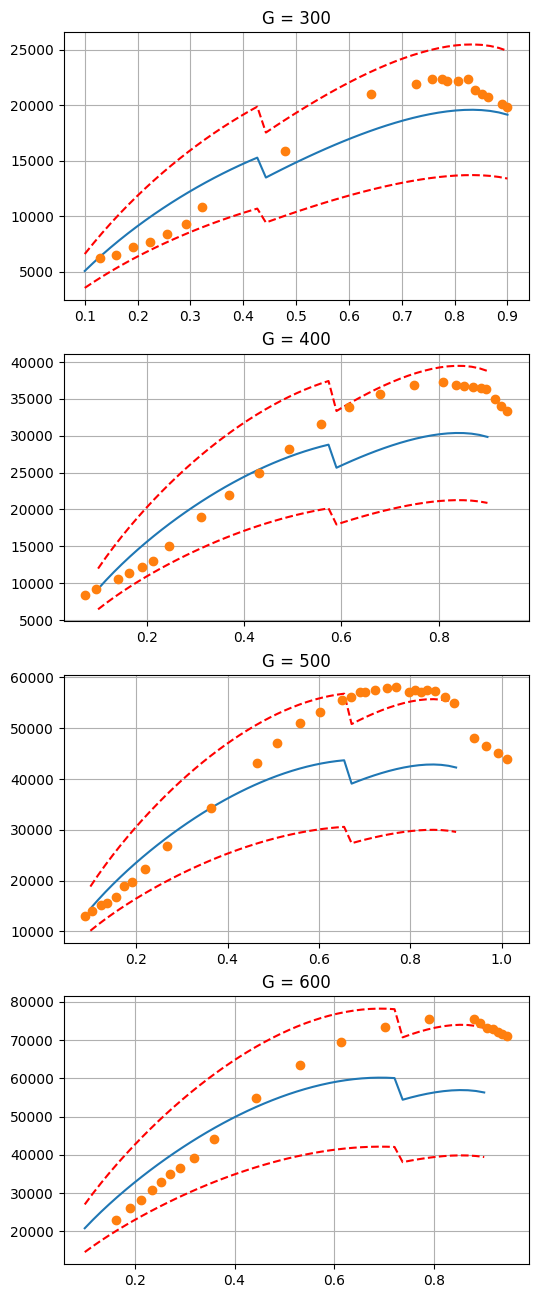

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6, 16))

for i in range(len(calculated_data)):
    x = research_1['x']
    y = calculated_data[i]['DpDz']
    x_exp = exp_df_9[i]['X']
    y_exp = exp_df_9[i]['Y'] 
    ax[i].plot(x, y)
    ax[i].plot(x, 0.7 * y, color='red', linestyle='--')
    ax[i].plot(x, 1.3 * y, color='red', linestyle='--')
    ax[i].plot(x_exp, y_exp * 1000, marker='o', linestyle='')
    ax[i].set_title(f'G = {research_1["G"][i]}' )
    ax[i].grid()


# Зададим пуь к папке с экспериментальными данными

In [20]:
exp_Nitrogen02_path = Path("/Users/andrey/Desktop/NIR/Datasets/Nitrogen_Water_02")

# Запишем экспериментальные данные в df

In [21]:
exp_Nitrogen02 = []
for file_path in exp_Nitrogen02_path.rglob('*'):
    if file_path.is_file():
        try:
            exp_Nitrogen02.append(pd.read_csv(file_path, sep='\t', decimal='.'))
        except Exception as e:
            print(f"Ошибка: {e}")

# Построение графиков для сравнения расчетных и экспериментальных данных 

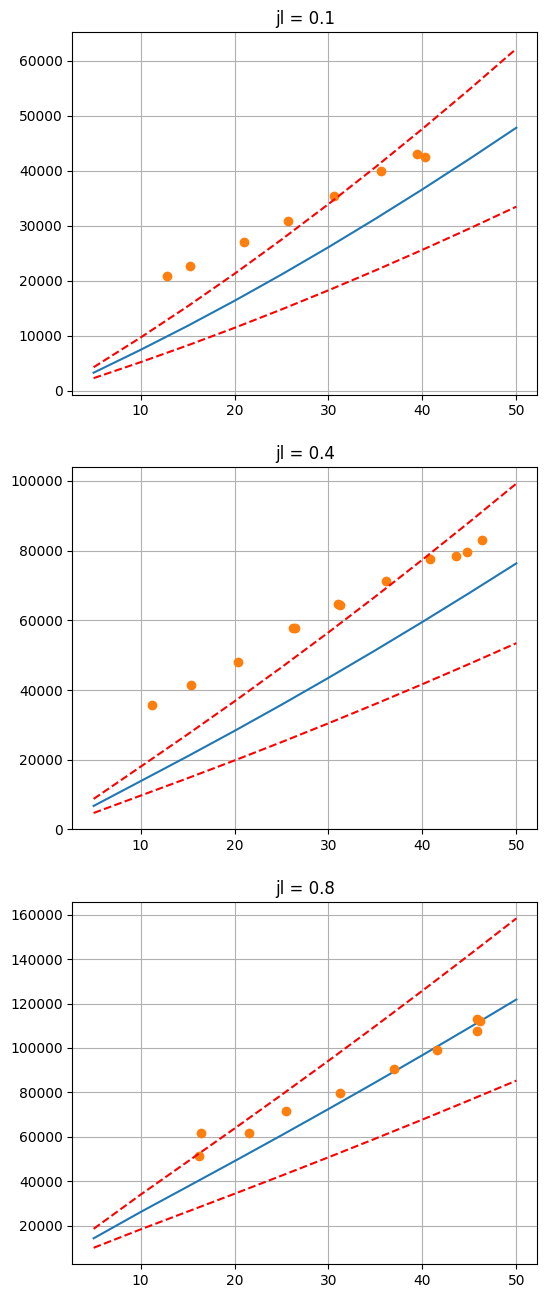

In [22]:
df = pd.DataFrame(second_experimental_setup.calculate())
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 16))
for idx, jl in enumerate(df['jl'].unique()):
    ax[idx].plot(df[df['jl'] == jl]['jg'], df[df['jl'] == jl]['DpDz'])
    ax[idx].plot(exp_Nitrogen02[idx]['X'], exp_Nitrogen02[idx]['Y'] * 1000, marker='o', linestyle='')
    ax[idx].plot(df[df['jl'] == jl]['jg'], 0.7 * df[df['jl'] == jl]['DpDz'], color='red', linestyle='--')
    ax[idx].plot(df[df['jl'] == jl]['jg'], 1.3 * df[df['jl'] == jl]['DpDz'], color='red', linestyle='--')
    ax[idx].set_title(f'jl = {jl}')
    ax[idx].grid()

In [23]:
path = Path("/Users/andrey/Desktop/NIR/Datasets/Graph12")
data = []

# Числовой порядок для Gr файлов
gr_files = [f for f in path.rglob('Dataset*.csv')]
gr_files_sorted = sorted(gr_files, key=lambda x: int(x.stem[7:]))

for file_path in gr_files_sorted:
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            data.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")


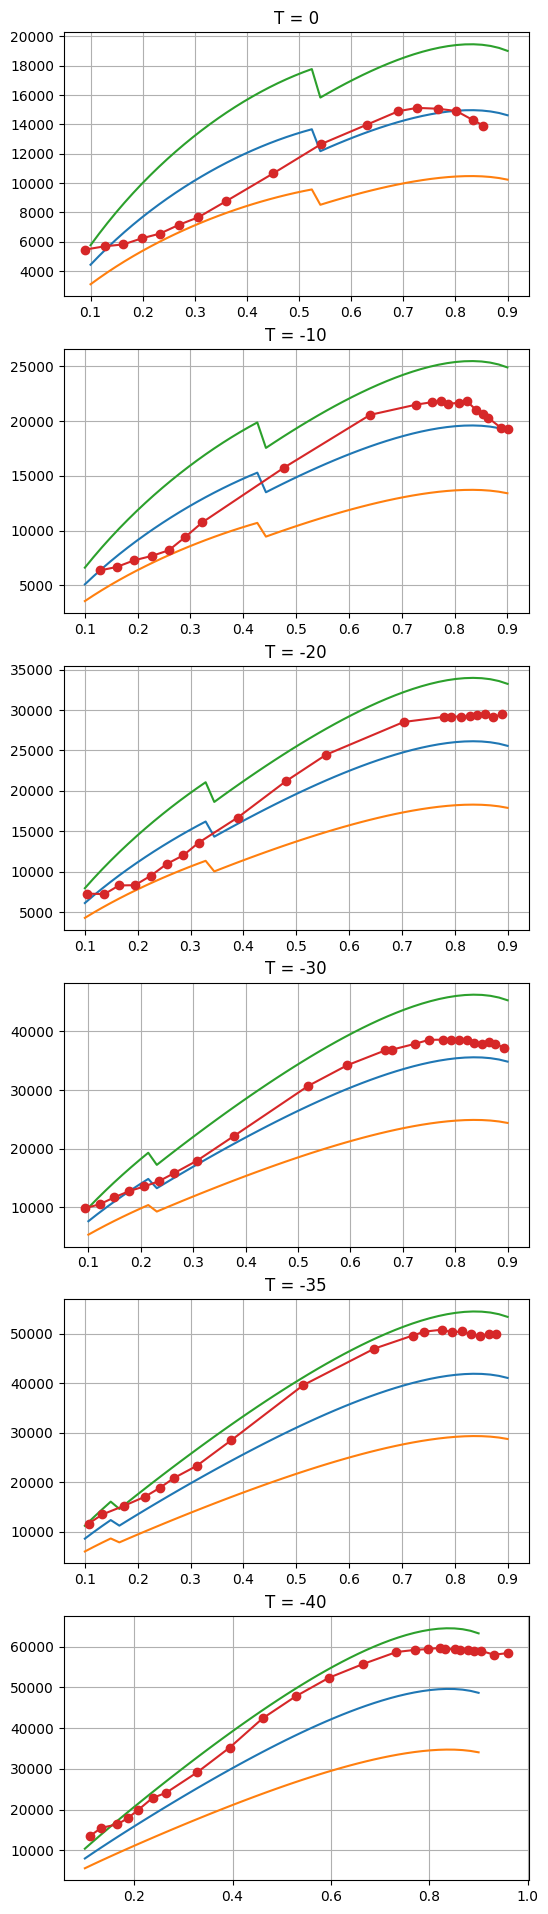

In [24]:
T = np.array([0, -10, -20, -30, -35, -40])
Nx = 50
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(6, 24))
for i, t in enumerate(T):
    params_t = {
            'Substance': 'CO2',
            'Temperature': t,
            'G': np.array([300]),
            'x': np.linspace(0.1, 0.9, Nx),
        }
    result = DpDz(g=9.8155, ki=350, d=0.00142, value_fb=False, thermodinamic_params=params_t)
    result = result.calculate()
    df = pd.DataFrame(result)
    

    ax[i].plot(params_t['x'], df['DpDz'])
    ax[i].plot(params_t['x'], 0.7 * df['DpDz'])
    ax[i].plot(params_t['x'], 1.3 * df['DpDz'])
    ax[i].plot(data[i]['X'], data[i]['Y'] * 1000, marker='o')
    ax[i].set_title(f'T = {t}')
    ax[i].grid()

    